## Deep Learning training with GRU, an extended FastText word embedding and Attention
We test here the combination of:
* an embedding layer which is initialized with a pretrained fasttext word embedding extended with custom embedding model
* a GRU (Gated Recurrent Unit) layer to capture word sequence representation
* an attention layer
* a dense layer to learn classification

We leverage the pre-trained fasttext word embedding model gracefully supplied by Facebook company at [https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md)

This general purpose word embedding model is extended with custom model generated by [fasttext_embedding_extension_builder.ipynb](fasttext_embedding_extension_builder.ipynb) script

It's inspired from https://www.kaggle.com/takuok/bidirectional-lstm-and-attention-lb-0-043

In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append('..')
from utils import vizu
from utils import serializer

embeddings_index = {}

In [2]:
from sklearn.model_selection import train_test_split

XTrain = pd.read_csv('../../data/staging_data/mispelling_fixed_clean_input_train.csv', sep=',')
YTrain = pd.read_csv('../../data/POSOS/label.csv', sep=';')

XTrain, XTest, YTrain, YTest = train_test_split(XTrain, YTrain, test_size=0.15, random_state=42)


###  <b>Build neural network with GRU and FastText embedding<b>

In [3]:
# hyper-parameters
num_classes = 51
vocabulary_size = 10000
sequence_length = 30
embedding_out_dims = 300
dropout_ratio = 0.15
num_epochs = 200
hidden_dims = 200
patience = 50

In [4]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(XTrain['question'])

sequences = tokenizer.texts_to_sequences(XTrain['question'])
XEncodedTrain = pad_sequences(sequences, maxlen=sequence_length, truncating='pre')

d:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
# load the French fasttext model
import os, re, csv, math, codecs
from tqdm import tqdm

if len(embeddings_index) == 0:
    
    f = codecs.open('../../pretrained_models/fasttext/wiki.fr.vec', encoding='utf-8')
    for line in tqdm(f):
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

1152466it [02:36, 7351.96it/s]


In [6]:
# complete the embedding mode with the custom one built by the script additional_fasttext_embedding_builder.ipynb
customEmbedding = serializer.loadEmbeddingVector('../../pretrained_models/fasttext_embedding_extension.txt')

for k,v in customEmbedding.items():
    embeddings_index[k] = v    

In [7]:
nb_words = min(vocabulary_size, len(tokenizer.word_index))

embedding_matrix = np.zeros((nb_words+1, embedding_out_dims))

for word, i in tokenizer.word_index.items():
    if i >= nb_words:
        continue
                
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        raise Exception("unknown word=" + word)

In [8]:
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints


class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [9]:
import tensorflow as tf
import keras
from keras.layers import CuDNNGRU, CuDNNLSTM
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Bidirectional
#config = tf.ConfigProto(device_count={"CPU": 32})

# configure tensorflow
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7, allow_growth = True)
config=tf.ConfigProto(gpu_options=gpu_options,allow_soft_placement=True)
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

# build neural network
model_lstm = Sequential()

# dimension reduction layer
model_lstm.add(
    Embedding(
        len(tokenizer.word_index)+1,
        embedding_out_dims,
        weights=[embedding_matrix],
        input_length=sequence_length,
        trainable=False))

# recurrent network layer
#model_lstm.add(Bidirectional(CuDNNLSTM(embedding_out_dims)))
model_lstm.add(Bidirectional(CuDNNGRU(embedding_out_dims,return_sequences=True)))

model_lstm.add(Attention(sequence_length))

# classification hidden layer
model_lstm.add(Dense(hidden_dims, activation="relu"))

# random node inactivation
model_lstm.add(Dropout(dropout_ratio))

# normalization layer
model_lstm.add(Dense(num_classes, activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 300)           2429400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 600)           1083600   
_________________________________________________________________
attention_1 (Attention)      (None, 600)               630       
_________________________________________________________________
dense_1 (Dense)              (None, 200)               120200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 51)                10251     
Total params: 3,644,081
Trainable params: 1,214,681
Non-trainable params: 2,429,400
__________________________________________________________

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from keras.utils.vis_utils import plot_model
plot_model(model_lstm, to_file='c:/Users/I051796/Projects/CES/report/model.png', show_shapes=True)

#pd.DataFrame(XEncodedTrain).to_csv('c:/Users/I051796/Projects/CES/notebooks/XEncodedTrain.txt', index=False, header=False)
XEncodedTrain = pd.read_csv('c:/Users/I051796/Projects/CES/notebooks/XEncodedTrain.txt', header=None)
XEncodedTrain = XEncodedTrain.values
XEncodedTrain.shape

### Train the network

In [10]:
YOneHotEncodedTrain = keras.utils.to_categorical(YTrain['intention'])

In [11]:
# generate the tensorflow board
call_back_board = keras.callbacks.TensorBoard(
    log_dir='c:/git/CES/logs',
    histogram_freq=0,
    batch_size=32,
    write_graph=True,
    write_grads=True,
    write_images=True,
    embeddings_freq=0,
    embeddings_layer_names=None,
    embeddings_metadata=None,
    embeddings_data=None)

# stop criterion to avoid overfitting
call_back_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=patience,
    verbose=0,
    mode='auto',
    baseline=None)

call_back_reduce_learning_rate = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=patience/2
)

# learn !
model_lstm.fit(
    XEncodedTrain,
    np.array(YOneHotEncodedTrain),
    validation_split=0.10,
    epochs=num_epochs,
    verbose=2,
    callbacks = [call_back_early_stopping, call_back_board, call_back_reduce_learning_rate])
    #callbacks = [call_back_early_stopping, call_back_board])
pass

Train on 6140 samples, validate on 683 samples
Epoch 1/200
 - 9s - loss: 2.7244 - acc: 0.3215 - val_loss: 2.2579 - val_acc: 0.3968
Epoch 2/200
 - 3s - loss: 1.8325 - acc: 0.5174 - val_loss: 1.7241 - val_acc: 0.5227
Epoch 3/200
 - 3s - loss: 1.3773 - acc: 0.6280 - val_loss: 1.5322 - val_acc: 0.5813
Epoch 4/200
 - 3s - loss: 1.0860 - acc: 0.6954 - val_loss: 1.4468 - val_acc: 0.6105
Epoch 5/200
 - 3s - loss: 0.8653 - acc: 0.7523 - val_loss: 1.3860 - val_acc: 0.6413
Epoch 6/200
 - 3s - loss: 0.7154 - acc: 0.7910 - val_loss: 1.4186 - val_acc: 0.6354
Epoch 7/200
 - 3s - loss: 0.5520 - acc: 0.8360 - val_loss: 1.3587 - val_acc: 0.6589
Epoch 8/200
 - 3s - loss: 0.4265 - acc: 0.8739 - val_loss: 1.4646 - val_acc: 0.6559
Epoch 9/200
 - 3s - loss: 0.3085 - acc: 0.9112 - val_loss: 1.5886 - val_acc: 0.6603
Epoch 10/200
 - 3s - loss: 0.2396 - acc: 0.9306 - val_loss: 1.6472 - val_acc: 0.6442
Epoch 11/200
 - 3s - loss: 0.1603 - acc: 0.9550 - val_loss: 1.7061 - val_acc: 0.6764
Epoch 12/200
 - 3s - loss: 

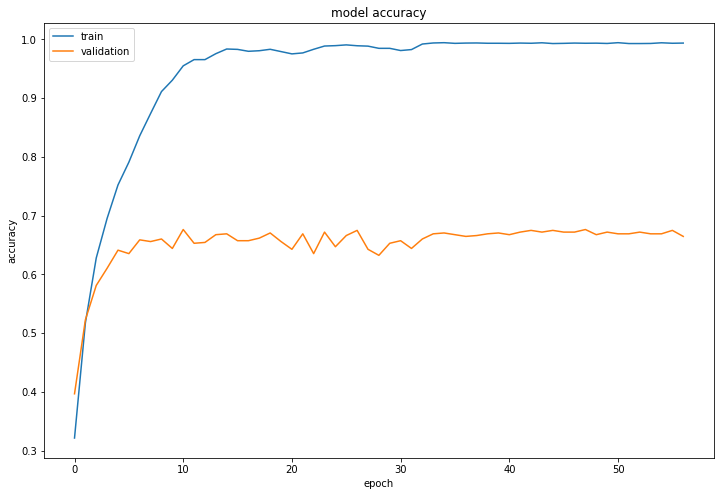

In [17]:
%matplotlib inline
vizu.plot_keras_model_learning_curve(model_lstm.history)

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.60      0.43      0.50        35
          1       0.00      0.00      0.00         4
          2       0.67      0.40      0.50         5
          3       0.00      0.00      0.00         1
          4       0.69      0.82      0.75        11
          5       0.50      0.39      0.44        18
          6       0.75      0.75      0.75         4
          7       0.50      1.00      0.67         1
          8       0.90      0.76      0.83        25
          9       0.43      0.43      0.43         7
         10       0.44      0.33      0.38        12
         11       0.57      0.48      0.52        27
         12       0.33      0.67      0.44         6
         13       0.36      0.42      0.38        12
         14       0.33      0.52      0.41        42
         15       0.67      0.50      0.57         4
         16       0.67      0.67      0.67         3
         17       0.50      0.50      0.50   

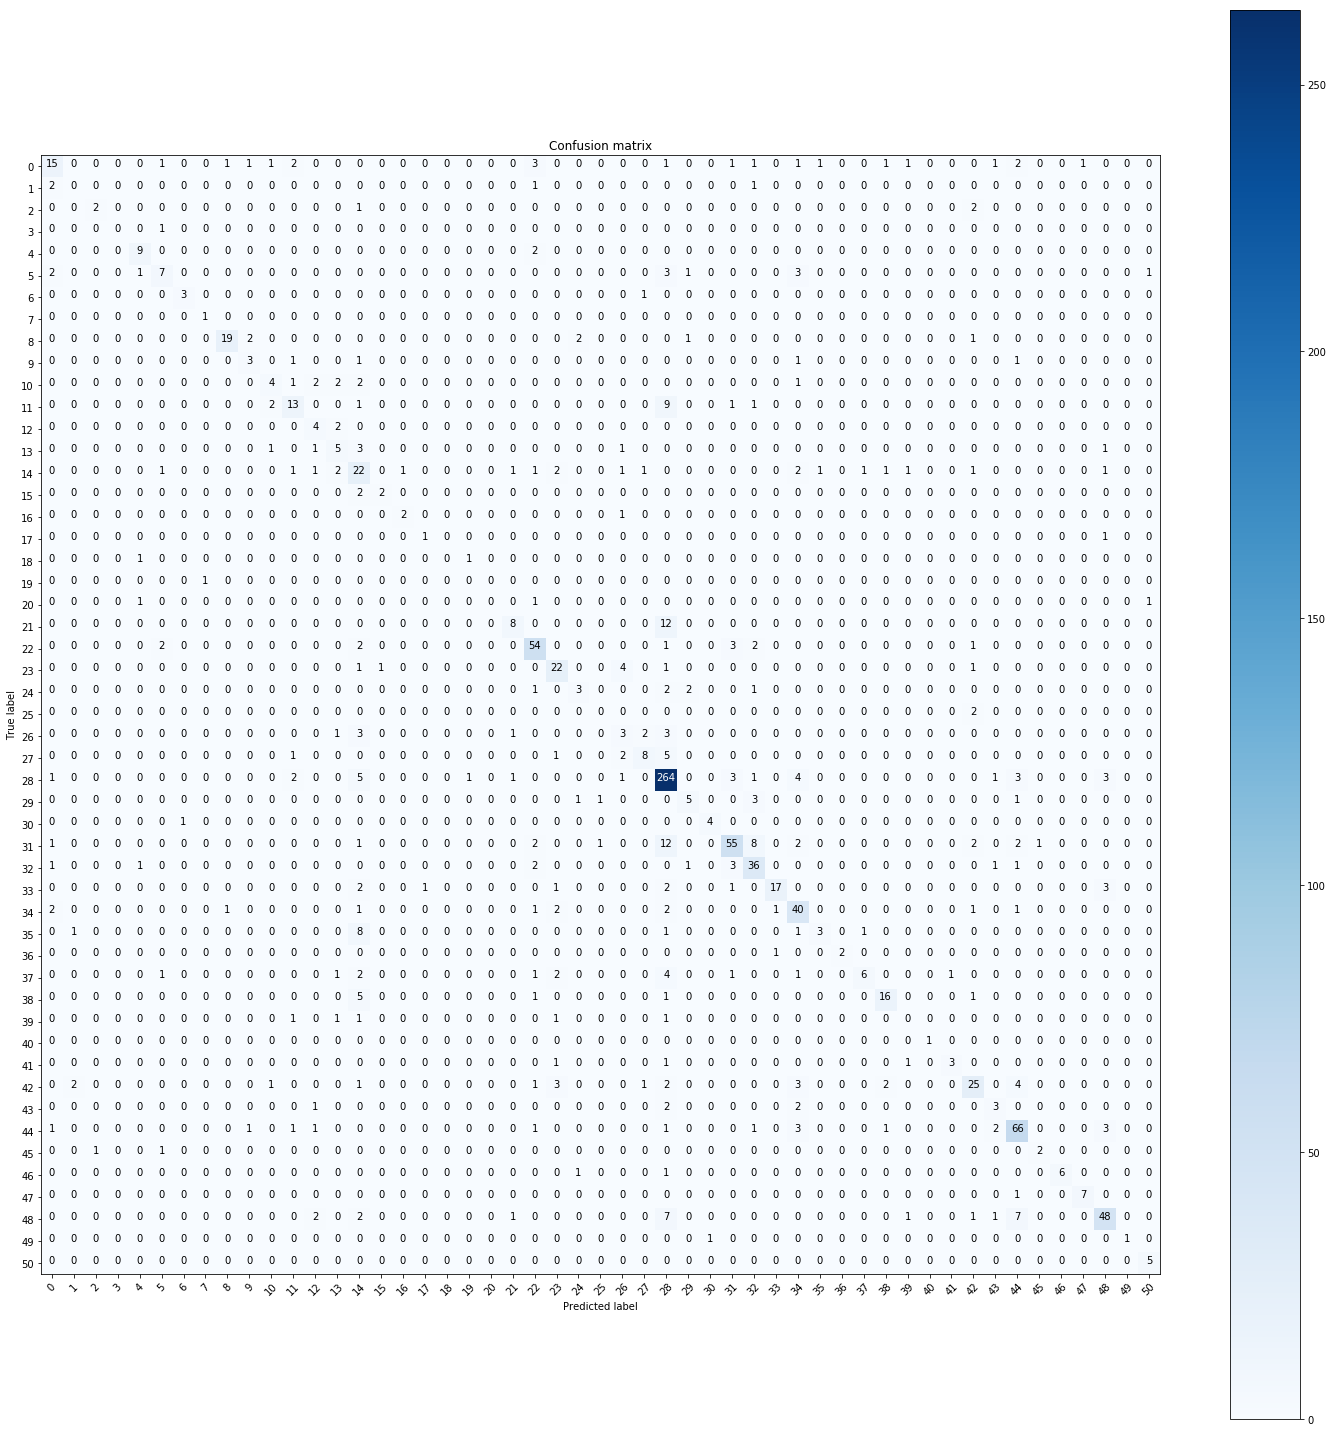

In [18]:
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

testSequences = tokenizer.texts_to_sequences(XTest['question'])
XEncodedTest = pad_sequences(testSequences, maxlen=sequence_length)
    
YTrue = YTest['intention']
YPredicted = model_lstm.predict_classes(XEncodedTest)
#YPredicted =list(map(lambda x : getHighProbaLabel(x), YProba))

cnf_matrix = confusion_matrix(YTrue, YPredicted)

print(sklearn.metrics.classification_report(YTrue, YPredicted))
 
plt.figure(figsize=(20,20))

vizu.plot_confusion_matrix(cnf_matrix, normalize=False, classes = np.unique(YTrain['intention']))

plt.show()

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


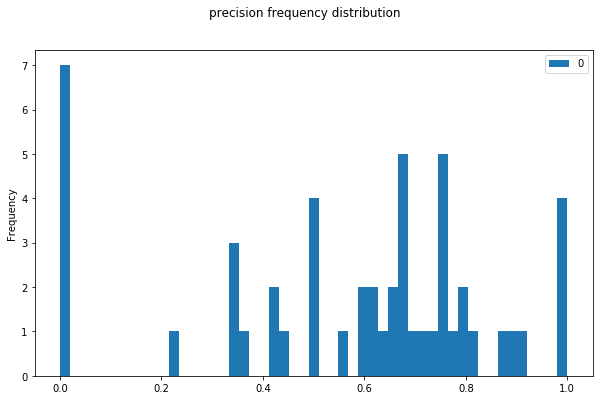

In [14]:
scores = sklearn.metrics.precision_recall_fscore_support(YTrue, YPredicted)

precision = pd.DataFrame(scores[0])
precision.plot(kind='hist',subplots=True,sharex=True,sharey=True,title='precision frequency distribution',figsize=(10,6),bins=51)
pass

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A32955B908>],
      dtype=object)

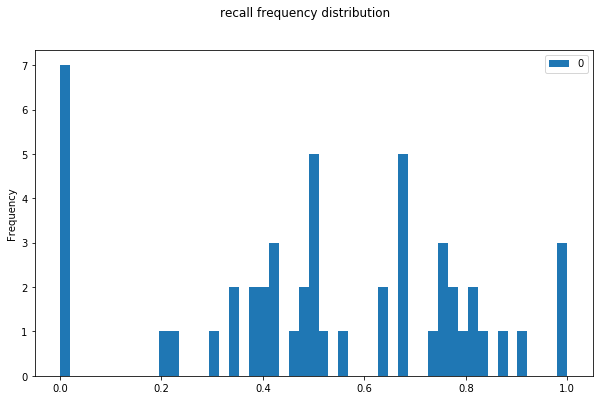

In [15]:
recall = pd.DataFrame(scores[1])
recall.plot(kind='hist',subplots=True,sharex=True,sharey=True,title='recall frequency distribution',figsize=(10,6),bins=51)


In [19]:
macroF1Score = sklearn.metrics.f1_score(YTrue, YPredicted, average='macro')
microF1Score = sklearn.metrics.f1_score(YTrue, YPredicted, average='micro')
print ("micro F1 score = {:1.4f} ; macro F1 score = {:1.4f}".format(microF1Score, macroF1Score))

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


micro F1 score = 0.6846 ; macro F1 score = 0.5278
